## Bibliothèque

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
from datetime import datetime, date
import time
import glob # for querying files within directory
import os # for filesize
from sys import platform

%matplotlib inline

## Distillation Class

In [ ]:
class Distiller(tf.keras.Model):
  def __init__(self, teacher, student):
      super(Distiller, self).__init__()
      
      # Attributs de la classe Distiller
      self.teacher = teacher
      self.student = student
      
  # Compilation du model
  def compile( self, optimizer, metrics, distillation_loss_fn, student_loss_fn, alpha = 0.1, temperature= 20):

    super(Distiller,self).compile(optimizer = optimizer, metrics= metrics )
    # losses
    self.distillation_loss_fn = distillation_loss_fn
    self.student_loss_fn = student_loss_fn

    # Hyperparameters
    self.temperature = temperature
    self.alpha = alpha
  
  # Training Step
  def train_step(self, data):
    # Unpack data
    x, y = data

    # Forward pass of teacher
    teacher_predictions = self.teacher(x, training=False)
    with tf.GradientTape() as tape:
      # student forward
      student_predictions = self.student(x, training= True)

      # Compute losses
      student_loss = self.student_loss_fn(y, student_predictions)
      distillation_loss = self.distillation_loss_fn(
          tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
          tf.nn.softmax(student_predictions / self.temperature, axis=1),
        )

      loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

    # Compute gradients
    trainable_vars = self.student.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)

    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Update the metrics configured in `compile()`.
    self.compiled_metrics.update_state(y, student_predictions)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update(
        {"student_loss": student_loss, "distillation_loss": distillation_loss}
    )
    return results

  # Test Step
  def test_step(self, data):
    
    # Unpack the data
    x, y = data

    # Compute predictions
    y_prediction = self.student(x, training=False)

    # Calculate the loss
    student_loss = self.student_loss_fn(y, y_prediction)

    # Update the metrics.
    self.compiled_metrics.update_state(y, y_prediction)

    # Return a dict of performance
    results = {m.name: m.result() for m in self.metrics}
    results.update({"student_loss": student_loss})
    return results


## Plotting History

In [ ]:
def plot_hist(los1,los2, accur1, accur2):
  plt.figure(figsize= (20,7))
  plt.subplot(121)
  plt.plot(accur1, label='KD Accuracy')
  plt.plot(accur2, label= 'Scratch Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.legend()


  plt.subplot(122)
  plt.plot(los1, label='KD Loss')
  plt.plot(los2,  label= 'Scratch Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.grid()
  plt.legend()
  plt.show()

## Data

In [ ]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()


# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

170508288/170498071 [==============================] - 11s 0us/step
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


## Building ResNet

In [ ]:
def resnet_layer(inputs,
                 num_filters=15,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature 
    map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of 
    filters is
    doubled. Within each stage, the layers have the same number 
    filters and the same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 15
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    outputs = layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

## Building model

In [ ]:
# Training parameters
BATCH_SIZE = 32  # orig paper trained all networks with batch_size=128
EPOCHS = 30

USE_AUGMENTATION = False
# Subtracting pixel mean improves accuracy
SUBTRACT_PIXEL_MEAN = False

NUM_CLASSES = np.unique(y_train).shape[0] # 10
COLORS = x_train.shape[3]

# Computed depth from supplied model parameter n
DEPTH = COLORS * 6 + 2

In [ ]:
# Input image dimensions.
input_shape = x_train.shape[1:]


# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean


# Create the neural network
Resnet50 = tf.keras.models.load_model("/content/drive/MyDrive/Stage/saved_models_KD/ResNet50_KD_CNN_Student")

Resnet50.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 32, 32, 15)   420         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 15)  60          ['conv2d_2[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 15)   0           ['batch_normalization[0][0]']

## Training Student From Scratch

In [ ]:
Epochs = 100
Batch = 32

In [ ]:
# Create the student
student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

# Clone student for later comparison
student_scratch = tf.keras.models.clone_model(student)

student.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 15)   420         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 15)  60          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 15)   0           ['batch_normalization[0][0]']

In [ ]:
# Training studen model from scratch
student_scratch.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

t1 = time.time()
scrratch_stud_hist2 = student_scratch.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
t2 = time.time()
time_scratch = t2 - t1

# Evaluate student on test dataset
student_scratch.evaluate(x_test, y_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 39s 17ms/step - loss: 1.4926 - sparse_categorical_accuracy: 0.4837
Epoch 2/100
1563/1563 [==============================] - 23s 15ms/step - loss: 1.1550 - sparse_categorical_accuracy: 0.6121
Epoch 3/100
1563/1563 [==============================] - 23s 14ms/step - loss: 1.0148 - sparse_categorical_accuracy: 0.6627
Epoch 4/100
1563/1563 [==============================] - 23s 14ms/step - loss: 0.9330 - sparse_categorical_accuracy: 0.6966
Epoch 5/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8714 - sparse_categorical_accuracy: 0.7203
Epoch 6/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.8222 - sparse_categorical_accuracy: 0.7367
Epoch 7/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7784 - sparse_categorical_accuracy: 0.7575
Epoch 8/100
1563/1563 [==============================] - 23s 15ms/step - loss: 0.7455 - sparse_categorical_accuracy: 0.7689
Epoch 9/100
1563/156

[1.4982373714447021, 0.6955000162124634]

## Training Student with KD

In [ ]:
dist = Distiller(Resnet50, student)
dist.compile(
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    distillation_loss_fn = tf.keras.losses.KLDivergence(),
    student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    alpha = 0.1,
    temperature = 20)



# Distill teacher to student
t1 = time.time()
dist_hist = dist.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
t2 = time.time()
time_dist = t2 - t1

# Evaluate student on test dataset
dist.evaluate(x_test, y_test)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 50s 30ms/step - sparse_categorical_accuracy: 0.4782 - student_loss: 1.4380 - distillation_loss: 7.3023e-05
Epoch 2/100
1563/1563 [==============================] - 47s 30ms/step - sparse_categorical_accuracy: 0.6011 - student_loss: 1.1166 - distillation_loss: 5.7432e-05
Epoch 3/100
1563/1563 [==============================] - 46s 30ms/step - sparse_categorical_accuracy: 0.6524 - student_loss: 0.9820 - distillation_loss: 5.0429e-05
Epoch 4/100
1563/1563 [==============================] - 46s 30ms/step - sparse_categorical_accuracy: 0.6858 - student_loss: 0.8914 - distillation_loss: 4.5926e-05
Epoch 5/100
1563/1563 [==============================] - 46s 30ms/step - sparse_categorical_accuracy: 0.7118 - student_loss: 0.8238 - distillation_loss: 4.2523e-05
Epoch 6/100
1563/1563 [==============================] - 46s 30ms/step - sparse_categorical_accuracy: 0.7306 - student_loss: 0.7678 - distillation_loss: 3.9837e-05
Epoch 7/100
1563/1563 [=====

[0.7336999773979187, 0.7781873941421509]

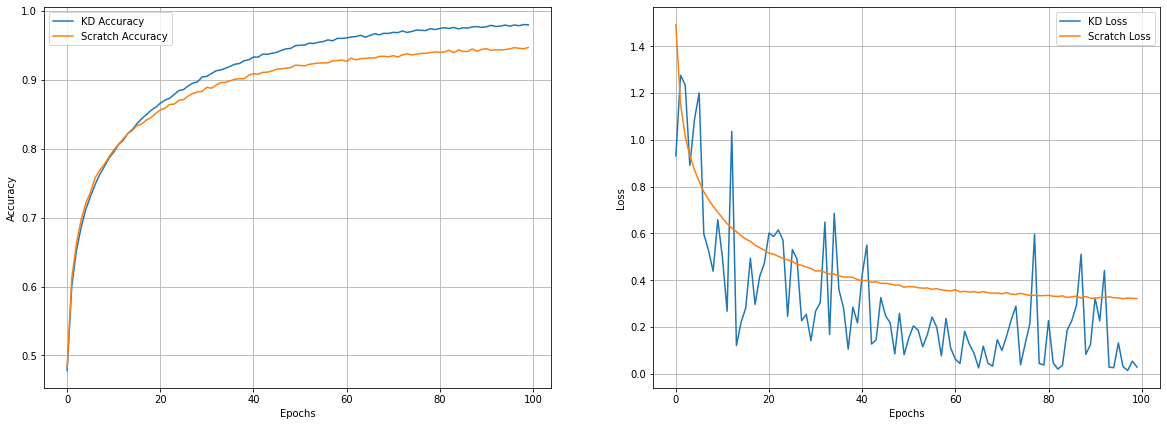

In [ ]:
plot_hist(dist_hist.history['student_loss'], scrratch_stud_hist2.history['loss'] ,dist_hist.history['sparse_categorical_accuracy'] , scrratch_stud_hist2.history['sparse_categorical_accuracy'])

## Training Time

In [ ]:
print("Training Time :")
print(" Knowledge Distillation :", time_dist // 60,'Min', time_dist - (time_dist // 60)*60,"s")
print(" Training from Scratch :", time_scratch // 60 ,"Min", time_scratch - (time_scratch // 60) * 60, "s")

Training Time :
 Knowledge Distillation : 80.0 Min 25.85997748374939 s
 Training from Scratch : 41.0 Min 24.62650489807129 s


In [ ]:
Compression_ratio = Resnet50.count_params()/ student.count_params()
print("Estimation des paramètres mémoire :")
print(" Ratio de compression :", Compression_ratio )
print(" Compression effectuée : ", (Resnet50.count_params()*4)/1e6, "Mo à ", (student.count_params()*4) /1e6 ,"Mo"  )

Estimation des paramètres mémoire :
 Ratio de compression : 9.699480369515012
 Compression effectuée :  2.68792 Mo à  0.27712 Mo


## Etude de l'effet du paramètre $T$ sur le Knowledge Distillation

In [ ]:
Epochs = 5
Batch = 32

In [ ]:
T = np.arange(1, 51,5 )
accur = []


for t in T:
  # Create the student
  student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

  dist = Distiller(Resnet50, student)
  dist.compile(
      optimizer = tf.keras.optimizers.Adam(),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
      distillation_loss_fn = tf.keras.losses.KLDivergence(),
      student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      alpha = 0.1,
      temperature = t)


  # Distill teacher to student
  dist_hist = dist.fit(x_train, y_train, epochs=Epochs, batch_size = Batch)
  

  # Evaluate student on test dataset
  score = dist.evaluate(x_test, y_test)
  accur.append(score[0])

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1563/1563 [==============================] - 52s 31ms/step - sparse_categorical_accuracy: 0.4711 - student_loss: 1.4541 - distillation_loss: 0.0444
Epoch 2/5
1563/1563 [==============================] - 47s 30ms/step - sparse_categorical_accuracy: 0.6080 - student_loss: 1.0988 - distillation_loss: 0.0335
Epoch 3/5
1563/1563 [==============================] - 46s 30ms/step - sparse_categorical_accuracy: 0.6633 - student_loss: 0.9529 - distillation_loss: 0.0287
Epoch 4/5
1563/1563 [==============================] - 46s 29ms/step - sparse_categorical_accuracy: 0.6987 - student_loss: 0.8607 - distillation_loss: 0.0258
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - sparse_categorical_accuracy: 0.6861 - student_loss: 0.8932
Epoch 1/5
1563/1563 [==============================] - 50s 30ms/step - sparse_categorical_accuracy: 0.4848 - student_loss: 1.4183 - distillation_loss: 8.4641e-04
Epoch 2/5
1563/1563 [==============================] - 47s 30ms/step - sparse_categorical_

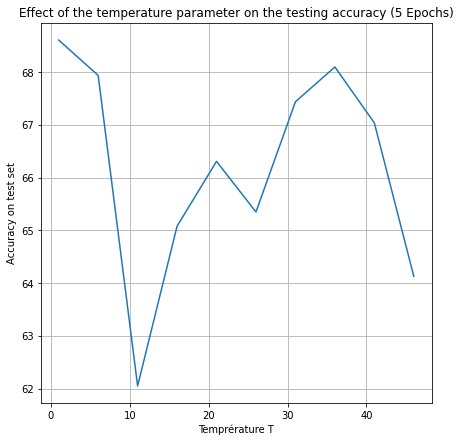

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(T, np.array(accur)* 100)
plt.xlabel('Temprérature T')
plt.ylabel("Accuracy on test set")
plt.title("Effect of the temperature parameter on the testing accuracy (5 Epochs)")

plt.grid()
plt.show()